In [1]:
import os 
if os.path.basename(os.getcwd()) == "notebooks": os.chdir("..")
import datajoint as dj
from datetime import datetime
from pathlib import Path
import re
import numpy as np
import intanrhdreader
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
from workflow.pipeline import lineage, culture, analysis
from workflow.pipeline.ephys import probe, ephys
from element_interface.utils import find_full_path
from workflow.utils.paths import (get_ephys_root_data_dir, get_raw_root_data_dir, get_subject_directory)

[2023-09-27 11:29:37,671][INFO]: Connecting utah-worker@db.datajoint.com:3306
[2023-09-27 11:29:38,152][INFO]: Connected utah-worker@db.datajoint.com:3306


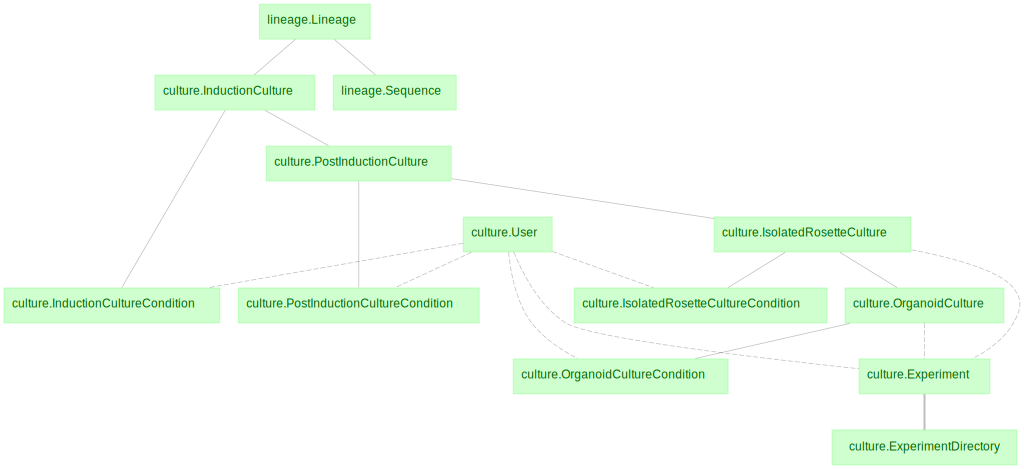

In [5]:
dj.Diagram(lineage) + dj.Diagram(culture)

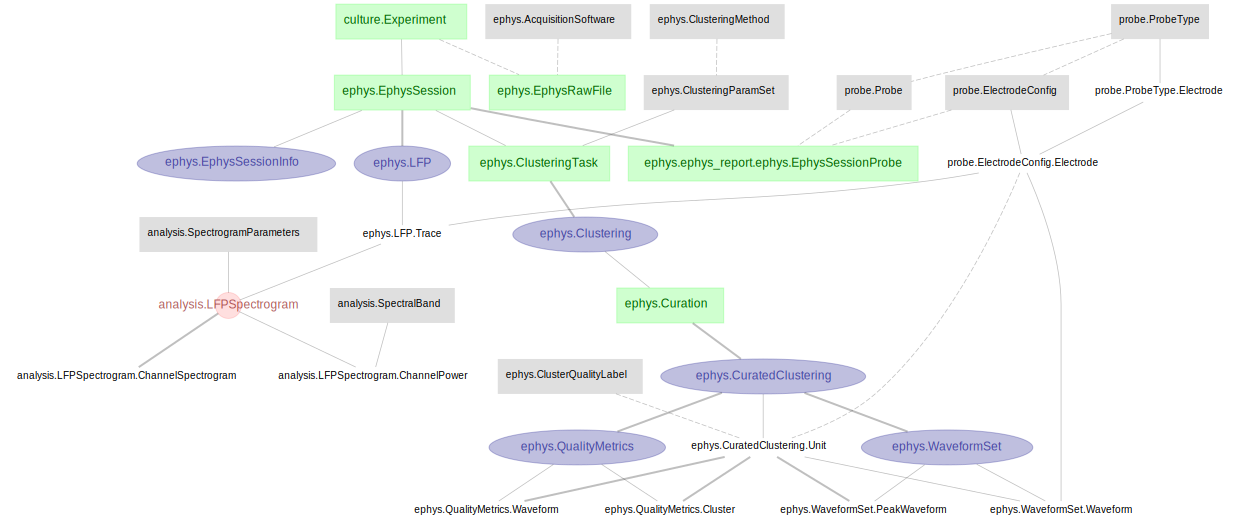

In [4]:
dj.Diagram(culture.Experiment) + dj.Diagram(probe) + dj.Diagram(ephys) + dj.Diagram(analysis)

In [5]:
organoid_key = dict(organoid_id="O17",
                    experiment_datetime=datetime.strptime("190722_204631", "%y%m%d_%H%M%S"))#"230630_024921"

In [6]:
# Insert into the table upstream from the ephys schema (i.e. culture.Experiment)
culture.Experiment.insert1(dict(
            **organoid_key,
            experiment_plan="ephys",
            experiment_directory="O17-20"
        ),
        skip_duplicates=True
    )

culture.Experiment()

organoid_id e.g. O17,experiment_datetime Experiment start date and time,user,lineage_id de-identified code (e.g. hmau001),induction_culture_date,induction_culture_plate,post_induction_culture_date,post_induction_culture_plate,isolated_rosette_culture_date Date for isolating the rosette,isolated_rosette_culture_plate,organoid_culture_date,organoid_culture_plate,"experiment_plan e.g. mrna lysate, oct, protein lysate, or matrigel embedding, ephys, tracing",experiment_directory Path to the subject data directory
O17,2019-07-22 20:46:31,None,None,None,None,None,None,None,None,None,None,ephys,O17-20
O17,2023-06-30 02:49:21,None,None,None,None,None,None,None,None,None,None,ephys,O17-20


### Insert into ProbeType, Probe, and ElectrodeConfig

In [14]:
probe_type = "NeuroNexus-A4x16-Poly2-5mm"
probe_full_name = "A4X16-Poly2-5mm-23s-200-177-H64LP_30mm"
probe_SN = "O17"

probe.ProbeType.insert1(dict(
        probe_type=probe_type,
        probe_full_name=probe_full_name,
    ),
    skip_duplicates=True
)

probe_config = dict(probe_type=probe_type,
                site_count_per_shank=16,
                col_spacing=None,
                row_spacing=20,
                white_spacing=None,
                col_count_per_shank=1,
                shank_count=1,
                shank_spacing=None
                )

electrode_layouts = probe.build_electrode_layouts(**probe_config)
probe.ProbeType.Electrode.insert(electrode_layouts, skip_duplicates=True)

probe.Probe.insert1(dict(
        probe=probe_SN,
        probe_type=probe_type,
        probe_comment="",
    ),
    skip_duplicates=True
)

channel_to_electrode_map = {"D-000": 0,
                            "D-001": 1,
                            "D-002": 2,
                            "D-003": 3,
                            "D-004": 4,
                            "D-005": 5,
                            "D-006": 6,
                            "D-007": 7,
                            "D-008": 8,
                            "D-009": 9,
                            "D-010": 10,
                            "D-011": 11,
                            "D-012": 12,
                            "D-013": 13,
                            "D-014": 14,
                            "D-015": 15}
electrode_keys = [
    dict(probe_type=probe_type, channel=c, electrode=e)
    for c, e in channel_to_electrode_map.items()
]

ephys.generate_electrode_config(
    probe_type=probe_type, electrode_keys=electrode_keys
)

{'electrode_config_hash': UUID('f2b8cfac-94cd-2564-da65-60493543f043')}

In [3]:
display(probe.ProbeType())
display(probe.ProbeType.Electrode())
display(probe.Probe())
display(probe.ElectrodeConfig())
display(probe.ElectrodeConfig.Electrode())

probe_type e.g. neuropixels_1.0,"probe_full_name full, non-abbreviated name of the probe"
NeuroNexus-A4x16-Poly2-5mm,A4X16-Poly2-5mm-23s-200-177-H64LP_30mm


probe_type e.g. neuropixels_1.0,"electrode electrode index, starts at 0","shank shank index, starts at 0, advance left to right","shank_col column index, starts at 0, advance left to right","shank_row row index, starts at 0.",x_coord (um) x coordinate of the electrode within the probe.,y_coord (um) y coordinate of the electrode within the probe.
NeuroNexus-A4x16-Poly2-5mm,0,0,0,0,0.0,0.0
NeuroNexus-A4x16-Poly2-5mm,1,0,0,1,0.0,20.0
NeuroNexus-A4x16-Poly2-5mm,2,0,0,2,0.0,40.0
NeuroNexus-A4x16-Poly2-5mm,3,0,0,3,0.0,60.0
NeuroNexus-A4x16-Poly2-5mm,4,0,0,4,0.0,80.0
NeuroNexus-A4x16-Poly2-5mm,5,0,0,5,0.0,100.0
NeuroNexus-A4x16-Poly2-5mm,6,0,0,6,0.0,120.0
NeuroNexus-A4x16-Poly2-5mm,7,0,0,7,0.0,140.0
NeuroNexus-A4x16-Poly2-5mm,8,0,0,8,0.0,160.0
NeuroNexus-A4x16-Poly2-5mm,9,0,0,9,0.0,180.0


probe unique identifier for this model of probe (e.g. serial number),probe_type e.g. neuropixels_1.0,probe_comment
O17,NeuroNexus-A4x16-Poly2-5mm,


electrode_config_hash,probe_type e.g. neuropixels_1.0,electrode_config_name user friendly name
f2b8cfac-94cd-2564-da65-60493543f043,NeuroNexus-A4x16-Poly2-5mm,0-15


electrode_config_hash,probe_type e.g. neuropixels_1.0,"electrode electrode index, starts at 0","channel channel name fetched from raw data (e.g., A-001)"
f2b8cfac-94cd-2564-da65-60493543f043,NeuroNexus-A4x16-Poly2-5mm,0,D-000
f2b8cfac-94cd-2564-da65-60493543f043,NeuroNexus-A4x16-Poly2-5mm,1,D-001
f2b8cfac-94cd-2564-da65-60493543f043,NeuroNexus-A4x16-Poly2-5mm,2,D-002
f2b8cfac-94cd-2564-da65-60493543f043,NeuroNexus-A4x16-Poly2-5mm,3,D-003
f2b8cfac-94cd-2564-da65-60493543f043,NeuroNexus-A4x16-Poly2-5mm,4,D-004
f2b8cfac-94cd-2564-da65-60493543f043,NeuroNexus-A4x16-Poly2-5mm,5,D-005
f2b8cfac-94cd-2564-da65-60493543f043,NeuroNexus-A4x16-Poly2-5mm,6,D-006
f2b8cfac-94cd-2564-da65-60493543f043,NeuroNexus-A4x16-Poly2-5mm,7,D-007
f2b8cfac-94cd-2564-da65-60493543f043,NeuroNexus-A4x16-Poly2-5mm,8,D-008
f2b8cfac-94cd-2564-da65-60493543f043,NeuroNexus-A4x16-Poly2-5mm,9,D-009


### Insert into `ephys.EphysRawFile`

Sample dataset directory structure including multiple subjects, a continuous recording session, and a single probe for each subject
  ```text
    O17-20_raw
    ├── *O17-20_230630_024921.rhd
    ├── *O17-20_230630_025021.rhd
    ├── *O17-20_230630_025121.rhd
    └── *O17-20_230630_025221.rhd
  ```

In [ ]:
organoid_key = dict(organoid_id="O17",
                    experiment_datetime=datetime.strptime("190722_204631", "%y%m%d_%H%M%S"))#"230630_024921"
organoid_key

{'organoid_id': 'O17',
 'experiment_datetime': datetime.datetime(2019, 7, 22, 20, 46, 31)}

In [31]:
subject_dir = get_subject_directory(organoid_key)

ingested_files = set([Path(file).name for file in ephys.EphysRawFile.fetch("file_path")])

data_files = set([Path(file).name for file in subject_dir.rglob("*.rhd")])

raw_data_list = []

for file in data_files.difference(ingested_files):
    start_date = re.search(r".*_(\d{6})_", file).groups()[0]
    
    filename_prefix, start_time = re.search(r"(.*)_(\d{6}_\d{6})", file).groups()
    
    start_time = np.datetime64(datetime.strptime(start_time, "%y%m%d_%H%M%S"))

    raw_data_list.append(
        {
        "file_path": subject_dir / file,
        **organoid_key,
        "acq_software": "Intan",
        "file_time": start_time,
        "parent_folder": subject_dir.name,
        "filename_prefix": filename_prefix,
        "file": subject_dir / file,
        })        

ephys.EphysRawFile.insert(raw_data_list)

display(ephys.EphysRawFile())

### Insert into `ephys.EphysSession`

In [ ]:
start_time = datetime.strptime("230630_024921", "%y%m%d_%H%M%S")
end_time = datetime.strptime("230630_025021", "%y%m%d_%H%M%S")

ephys.EphysSession.insert1(
        {**organoid_key, 
        "insertion_number": 0, 
        "start_time": start_time, 
        "end_time": end_time, 
        "session_type": "lfp"
        } 
    )

ephys.EphysSessionProbe.insert1(
        {**organoid_key, 
        "insertion_number": 0, 
        "start_time": start_time, 
        "end_time": end_time, 
        "probe": "O17",
        "electrode_config_hash": "f2b8cfac-94cd-2564-da65-60493543f043"
        } 
)

ephys.EphysSessionInfo.populate()
ephys.LFP.populate()

In [ ]:
display(ephys.EphysSession())
display(ephys.EphysSessionProbe())
display(ephys.EphysSessionInfo())
display(ephys.LFP())
display(ephys.LFP.Trace())

### Plot data


In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import signal

TARGET_SAMPLING_RATE = 2500

session_key = (ephys.EphysSession - "session_type='spike_sorting'" & organoid_key).fetch1("KEY")

# Load the data
files = (
    ephys.RawData
    & f"start_time BETWEEN '{session_key['start_time']}' AND '{session_key['end_time']}'"
).fetch("file_path", order_by="start_time")
file = files[0]  # plot the first file
data = intanrhdreader.load_file(file)

header = data.pop("header")
lfp_sampling_rate = header["sample_rate"]
powerline_noise_freq = header["notch_filter_frequency"]  # in Hz
downsample_factor = int(lfp_sampling_rate / TARGET_SAMPLING_RATE)

channels = [
    ch["native_channel_name"] for ch in data["amplifier_channels"]
]  # channels with raw ephys traces
lfp_traces = data["amplifier_data"]
lfp_data = {ch: lfp for ch, lfp in  zip(channels, lfp_traces)}

In [ ]:
# plot all channels
fig, ax = plt.subplots(figsize=(20, 10))
ytick_loc = []
for i, (ch, lfp) in enumerate(lfp_data.items()): 
    ytick_loc.append(i * 500)
    ax.plot(data["t"], lfp + ytick_loc[-1], linewidth=0.1)
ax.set_yticks(ytick_loc)
ax.set_yticklabels(lfp_data.keys())
ax.tick_params(length=0)
ax.set(xlabel="Time (s)", title=Path(file).name)
sns.despine(right = True, left = True)
plt.show()

In [ ]:
# Plot raw vs. downsampled data
channel = "D-002"
nb_data_points = 20000   
fig, ax = plt.subplots(figsize=(20, 4))

timestamps, lfp = data["t"][:nb_data_points], lfp_data[channel][:nb_data_points]
timestamps_downsampled, lfp_downsampled = timestamps[::downsample_factor], lfp[::downsample_factor]

ax.plot(timestamps, lfp, 'k', linewidth=0.6, alpha=0.7, label="raw")
ax.plot(timestamps_downsampled, lfp_downsampled, 'm', linewidth=1, label="downsampled")
ax.set(xlabel="Time (s)", ylabel="Amplitude (μV)", title=f"{Path(file).stem}.rhs - {channel}")
sns.despine()
plt.legend(loc='center left', bbox_to_anchor=(0.98, 0.5)) 
plt.show()

In [ ]:
# Raw data vs. denoised vs. lowpass-filtered
b_notch, a_notch = signal.iirnotch(
    w0=powerline_noise_freq, Q=30, fs=TARGET_SAMPLING_RATE
)
lfp_denoised = signal.filtfilt(b_notch, a_notch, lfp_downsampled)

# Lowpass filter
b_butter, a_butter = signal.butter(
    N=4, Wn=1000, btype="lowpass", fs=TARGET_SAMPLING_RATE
)
lfp_lowpass = signal.filtfilt(b_butter, a_butter, lfp_denoised)

fig, ax = plt.subplots(figsize=(20, 4))
ax.plot(timestamps_downsampled, lfp_downsampled, 'k', linewidth=1, alpha=0.7, label="downsampled")
ax.plot(timestamps_downsampled, lfp_denoised, 'g', linewidth=1, alpha=0.7, label="denoised")
ax.plot(timestamps_downsampled, lfp_lowpass, 'm', linewidth=1, alpha=0.7, label="lowpass")

ax.set(xlabel="Time (s)", ylabel="Amplitude (μV)", title=f"{Path(file).stem}.rhs - {channel}")
sns.despine()
plt.legend(loc='center left', bbox_to_anchor=(0.98, 0.5)) 
plt.show()